## Figure 4 time series of ASC and cross slope heat transport in individual bins

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from dask.distributed import Client
import matplotlib.colors as col
import matplotlib.gridspec as gs

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

figdir = '/g/data/g40/akm157/figures/ASC_heat_trans/time_series/'

In [2]:
client = Client(memory_limit='240gb',n_workers=48)
client

2025-04-11 20:14:19,042 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,048 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,051 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,055 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,058 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,061 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20:14:19,064 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 240gb due to system memory limit of 125.19 GiB
2025-04-11 20

<Client: 'tcp://127.0.0.1:42817' processes=48 threads=48, memory=5.87 TiB>

In [3]:
exp = '01deg_jra55v140_iaf_cycle3'
start_time= '1958-01-01'
end_time= '2018-12-31'
lat_range = slice(-90,-59)
isobath_depth = 1000

session = cc.database.create_session()

## First open u_along in density layers to use for compositing, and to show in time series:

In [4]:
# Load the along-slope velocity field for annual time series
u_along = xr.open_mfdataset('/g/data/ik11/users/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))
u_along_da_months.load();

####################

# load monthly water mass mask:
age_mask_monthly = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

# select out CDW layer:
u_along_da_months_binned_CDW = (age_mask_monthly.CDW_mask*u_along_da_months)

####################

# get volume for averaging across density layers:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

# do volume-weighted density average and annual averaging:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume

U_along_annual_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_annual_binned_CDW_volav = U_along_annual_binned_CDW_volav.load()

# Need to multiply by daily mask BEFORE taking climatology!! 

In [5]:
# Load the along-slope velocity field, seasonal climatology using daily data
# NEED THIS AS TIME SERIES NOT CLIMATOLOGY:
u_along = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_sigma_daily_10deg/OM2_01_iaf_cycle3/U_daily_10deg_****-**.nc')
####################

# load daily climatology water mass mask:
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/CDW_****-**.nc')

# select out CDW layer:
u_along_clima_binned_CDW = (age_mask_daily.CDW_mask*u_along)

####################

# get volume for averaging across density layers:
# NEED THIS AS TIME SERIES NOT CLIMATOLOGY:
vol_bins = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/VOL*.nc')
# do volume-weighted density average:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.Volume).mean('potrho0')/vol_bins.mean('potrho0').Volume

U_along_clima_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_clima_binned_CDW,vol_bins)

# compute seasonal climatology:
U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.groupby('time.dayofyear').mean('time')

U_along_clima_binned_CDW_volav = U_along_clima_binned_CDW_volav.load()

## Then open CSHT in density layers for time series:

In [7]:
# Load CSHT field annual
CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask_monthly.CDW_mask * CSHT_along_monthly )

# annual averaging and sum over layers:
CSHT_annual_binned_CDW = CSHT_months_binned_CDW.groupby('time.year').mean('time').sum(dim = 'potrho0')

# Need to multiply by daily mask BEFORE taking climatology!! 

In [10]:
# climatological averaging:
CSHT_along_daily = CSHT_along

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask_daily.CDW_mask * CSHT_along_daily )

# sum over layers:
CSHT_clima_binned_CDW = CSHT_months_binned_CDW.sum(dim = 'potrho0')

# compute seasonal climatology:
CSHT_clima_binned_CDW = CSHT_clima_binned_CDW.groupby('time.dayofyear').mean('time')
CSHT_clima_binned_CDW = CSHT_clima_binned_CDW.load()

## First need to open correlation data to figure out what longitude bins we want:

In [11]:
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/'
file_extension = 'agemaskCDW_volav_corr'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()

high_corr_lons = r_sq_annual_10deg.where(r_sq_annual_10deg>0.3,drop=True).lon_bins.values

In [12]:
longitude_slices = np.array([-63.5,-133.5,-243.5,-143.5,-173.5,-103.5, -33.5, -13.5, 76.5,-263.5])
## Check if high_correlation lons align with the regions we have selected:
print(np.isin(longitude_slices,high_corr_lons))
regions = ['West Antarctic Peninsula', 'Getz East', 'Totten',\
           'Getz West', 'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

[ True  True False  True  True  True  True  True  True  True]


## Then plot interannual and seasonal time series for the same 3 regions in Figure 3

# Check interannual time series here!! I think it is doing wrong region maybe?

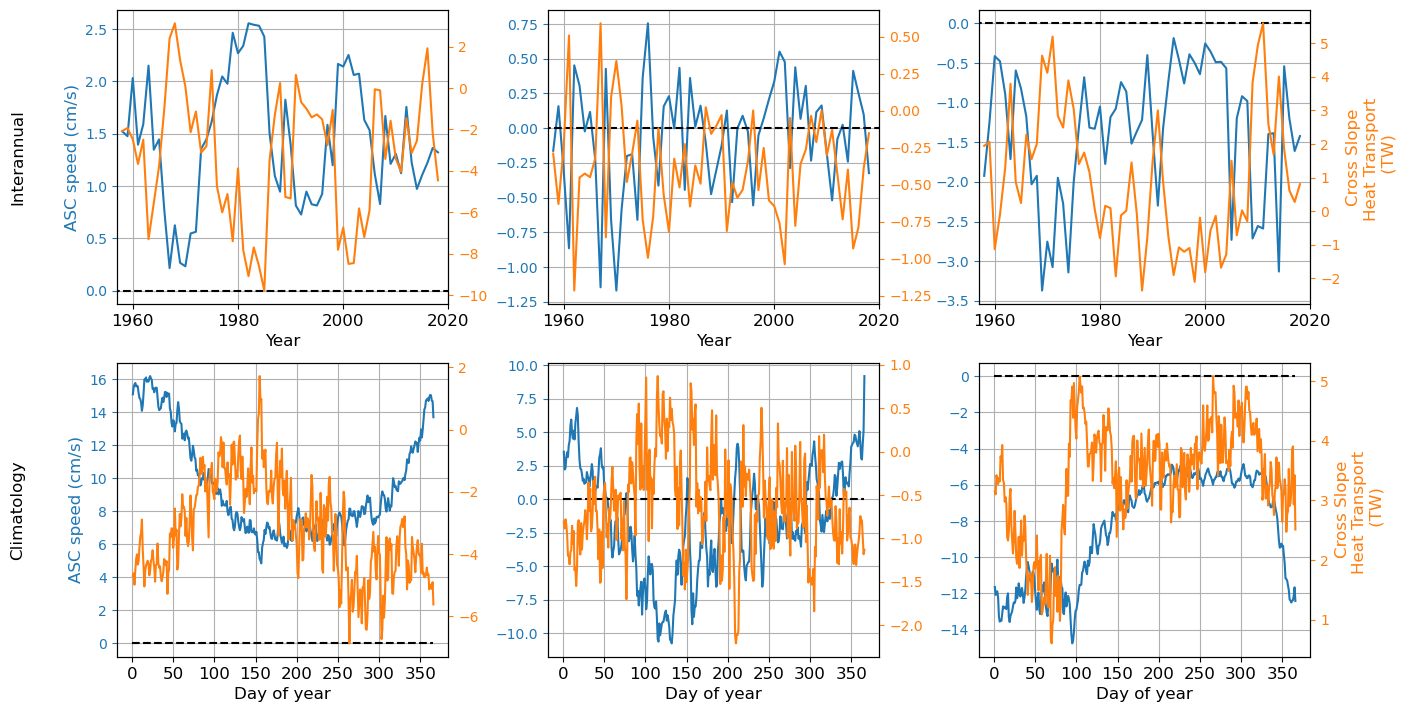

In [15]:
regions_selected = ['Getz East', 'West Antarctic Peninsula', 'Glomar']
inds_regions = np.where(np.isin(regions, regions_selected))[0]
fontsize=12

fig = plt.figure(figsize=(22*0.7, 12*0.7))

# Create a GridSpec for a 3x4 grid
grid = gs.GridSpec(nrows=2, ncols=3, figure=fig)
grid.update(hspace=0.2, wspace=0.3)  # Adjust vertical and horizontal spacing

# Initialize a list to store axes
axes = []

# Loop through the 3x4 grid to create subplots
for j in range(inds_regions.size):  # Loop over rows

    i = inds_regions[j]

    ax3 = fig.add_subplot(grid[0, j])
    ax4 = fig.add_subplot(grid[1, j])
    ###################
    
    ax3_HT=ax3.twinx()
    ax3.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC')
    ax3.plot([1956,2024],[0,0],\
             linestyle='--',color='black')
    ax3_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color='tab:orange')
    # ax3.set_ylim(u_along_lims[i])
    # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    if j == 0:    
        ax3.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
    # ax3_HT.set_ylim(CSHT_lims[i])
    # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    if j == inds_regions.size-1:
        ax3_HT.set_ylabel('Cross Slope\nHeat Transport \n (TW)',fontsize=fontsize,color='tab:orange')
    
    ax3.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax3.grid()
    ax3.set_xlim(1957,2020)
    ax3.set_xlabel('Year',fontsize=fontsize)
    ax3.tick_params(axis='y', colors='tab:blue')  # Left y-axis ticks and labels in blue
    ax3_HT.tick_params(axis='y', colors='tab:orange')  # Right y-axis ticks and labels in orange

    ################
    
    ax4_HT=ax4.twinx()
    ax4.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[i])*100,label='ASC')
    ax4.plot([0,365],[0,0],\
             linestyle='--',color='black')
    ax4_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[i])/1e12),\
                label='CSHT',color='tab:orange')
    # ax3.set_ylim(u_along_lims[i])
    # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    if j == 0:    
        ax4.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
    # ax3_HT.set_ylim(CSHT_lims[i])
    # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    if j == inds_regions.size-1:
        ax4_HT.set_ylabel('Cross Slope\nHeat Transport \n (TW)',fontsize=fontsize,color='tab:orange')
    ax4.set_xlabel('Day of year',fontsize=fontsize)
    # ax4.set_xticks(ticks=np.arange(1960,2021,10),labels=np.arange(1960,2021,10), fontsize=14)
    ax4.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50),fontsize=fontsize)
    #ax4.set_xlim(1,12)
    ax4.grid()
    # Set tick colors
    ax4.tick_params(axis='y', colors='tab:blue')  # Left y-axis ticks and labels in blue
    ax4_HT.tick_params(axis='y', colors='tab:orange')  # Right y-axis ticks and labels in orange

ax3.text(-2.9,0.5, 'Interannual', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
ax4.text(-2.9,0.5, 'Climatology', fontsize=fontsize, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)

plt.tight_layout()
figure_path = figdir+'selected_time_series.png'
#plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
# Show the plots
plt.show()

## Plot interannual and seasonal time series for all regions

In [16]:
len(longitude_slices)

10

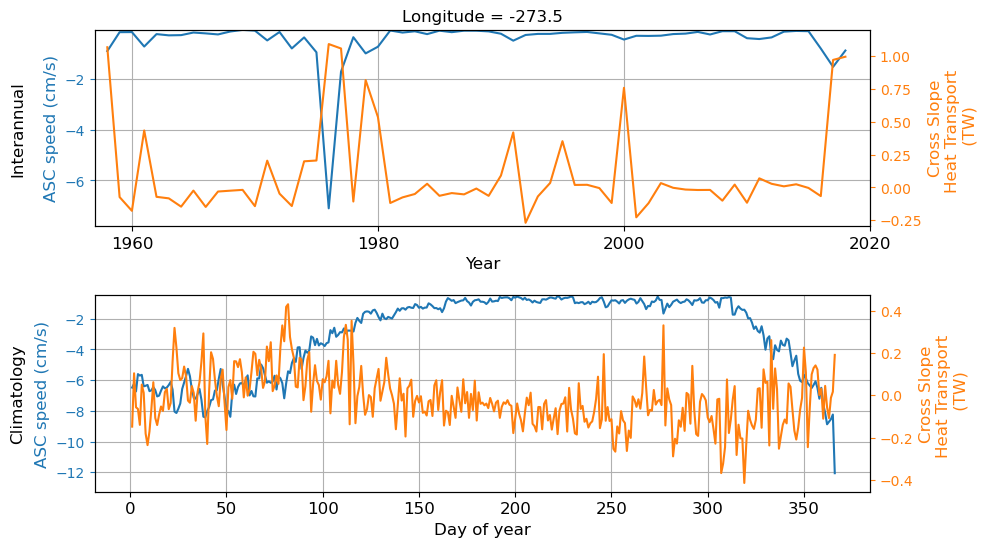

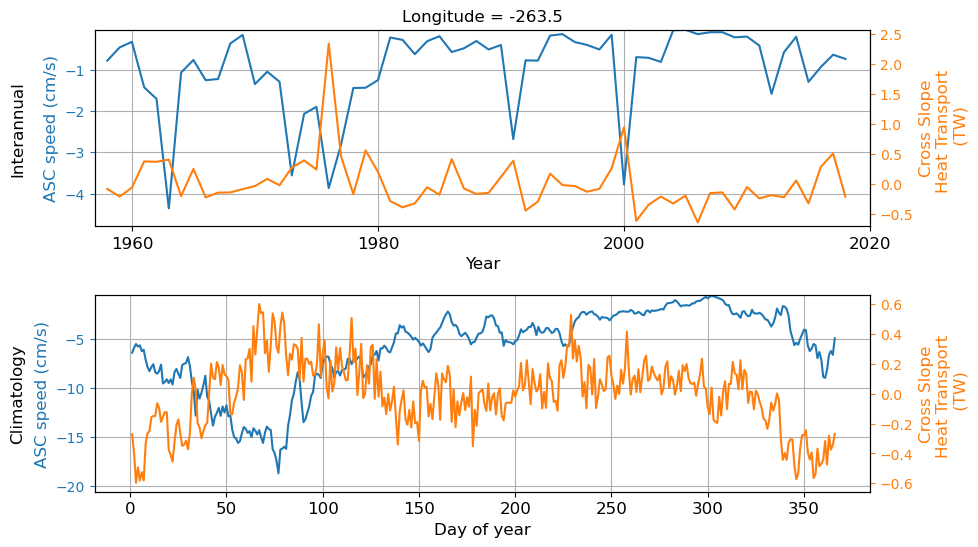

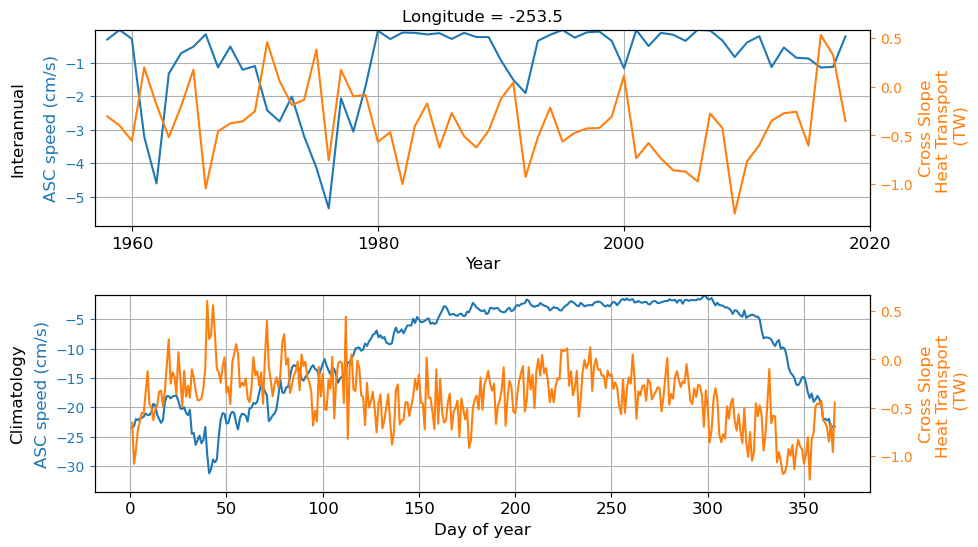

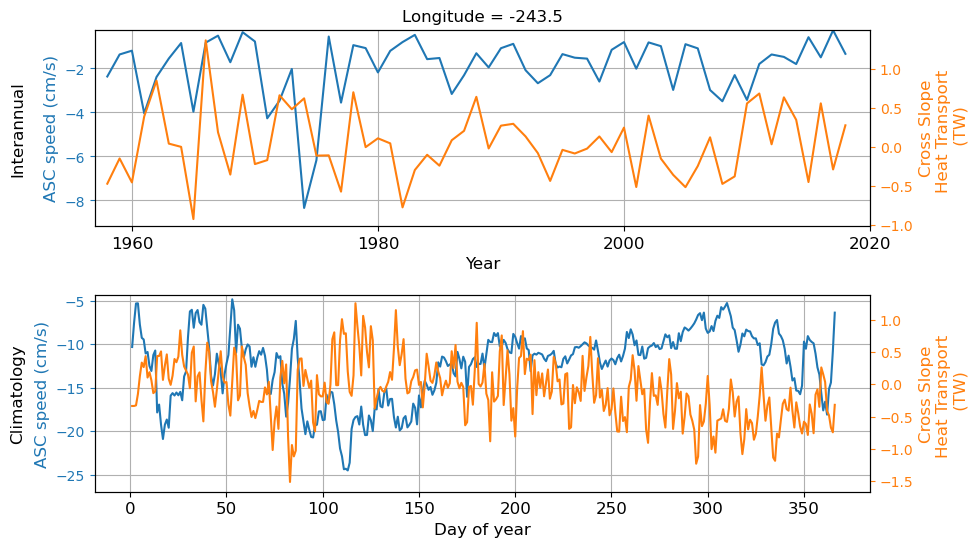

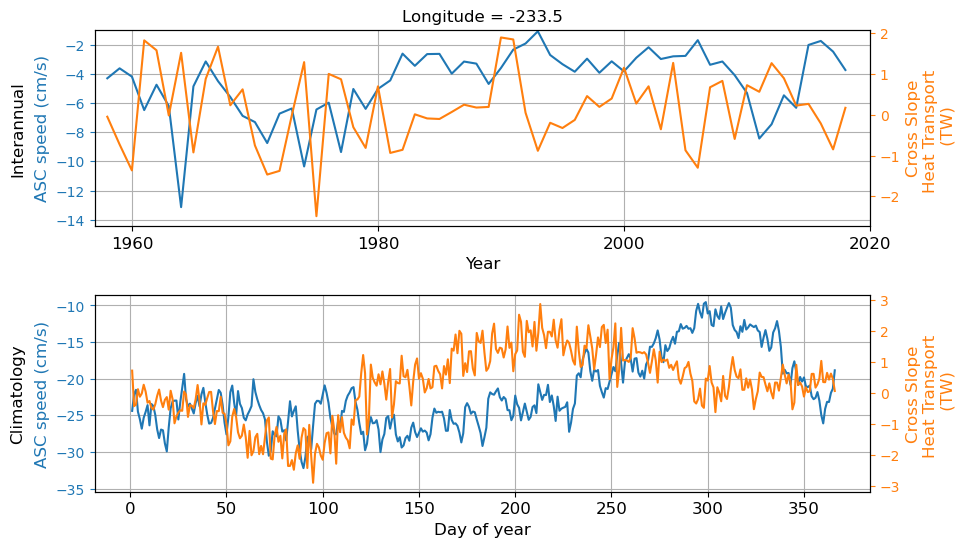

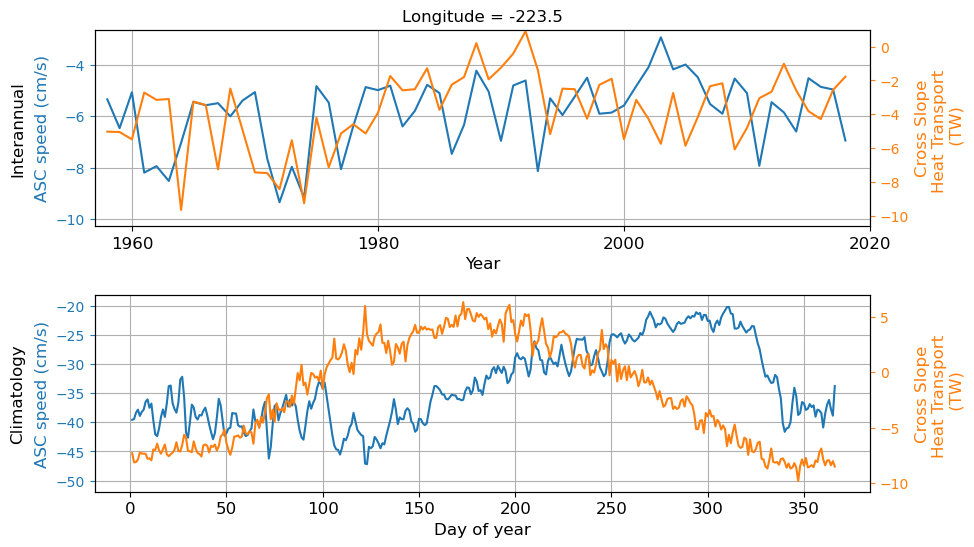

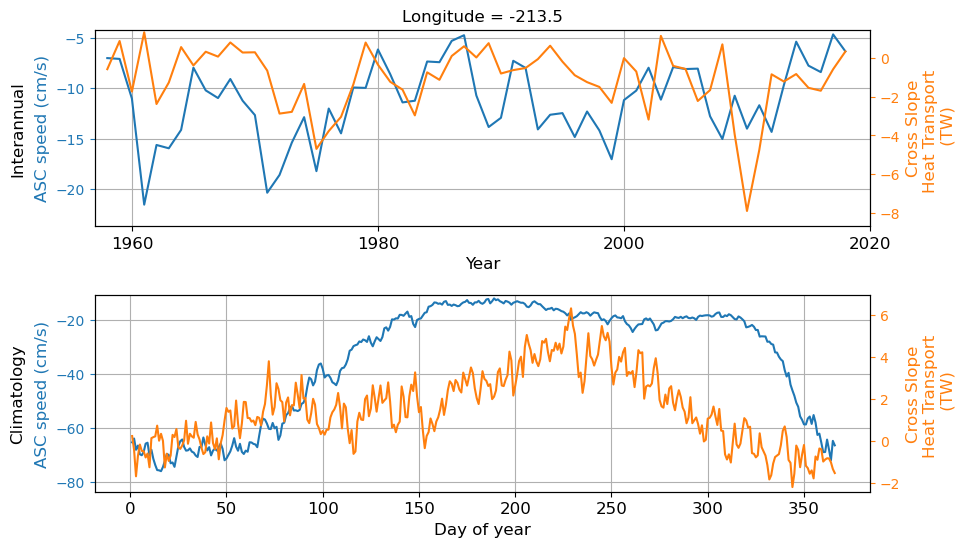

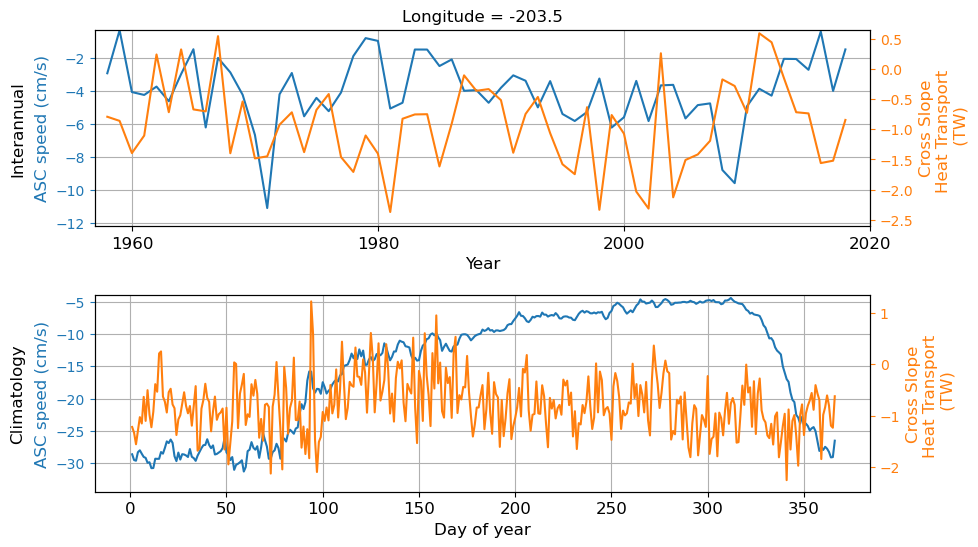

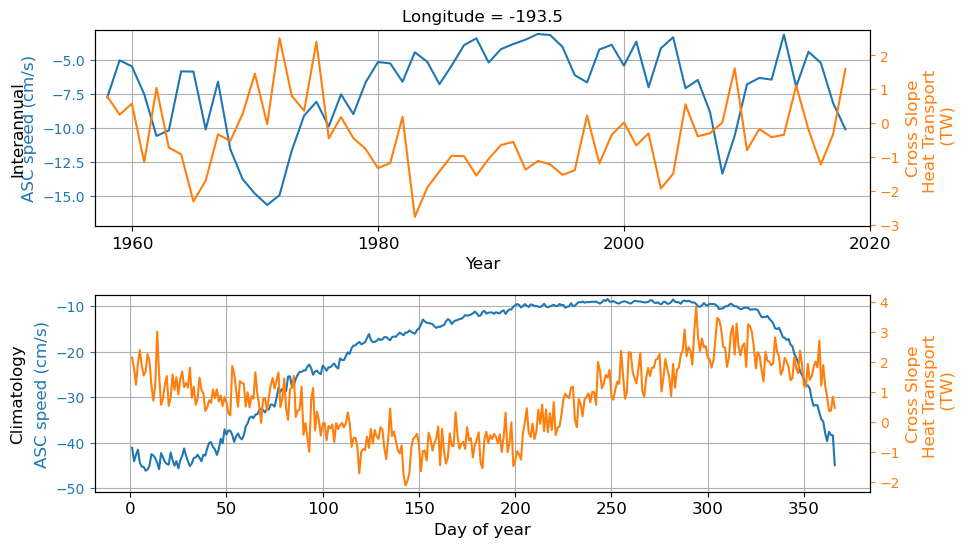

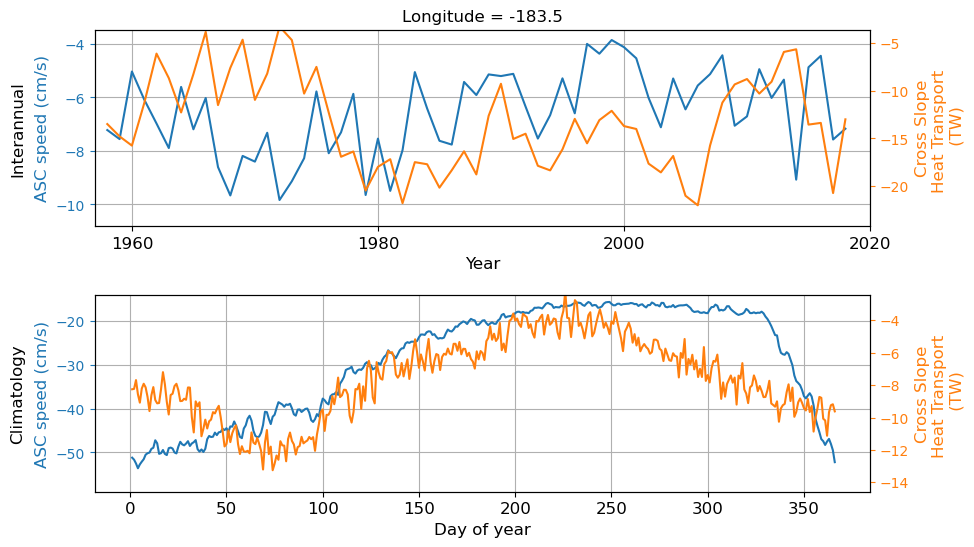

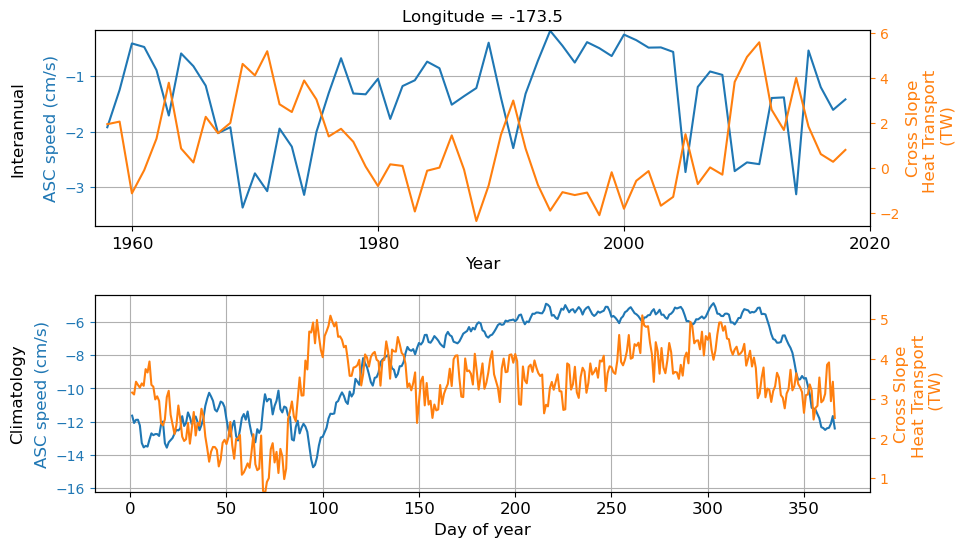

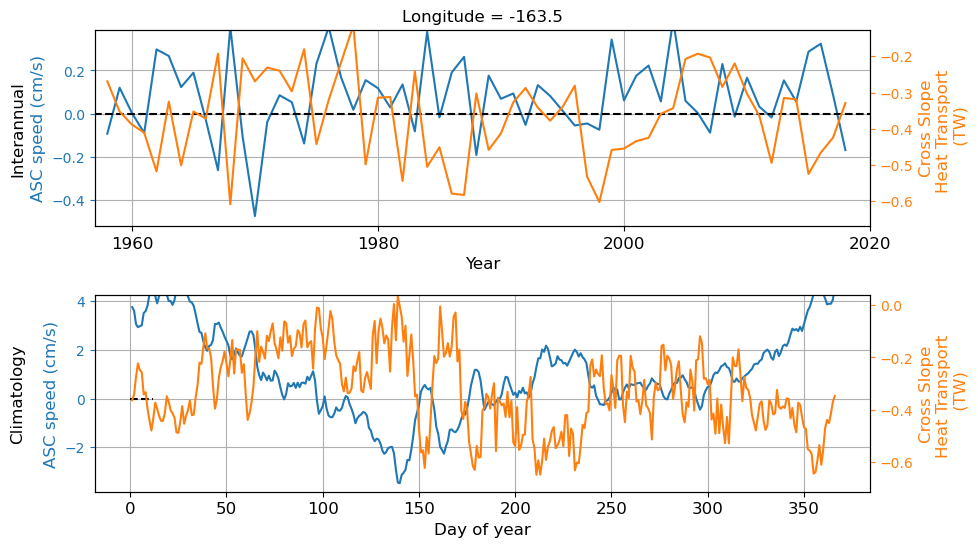

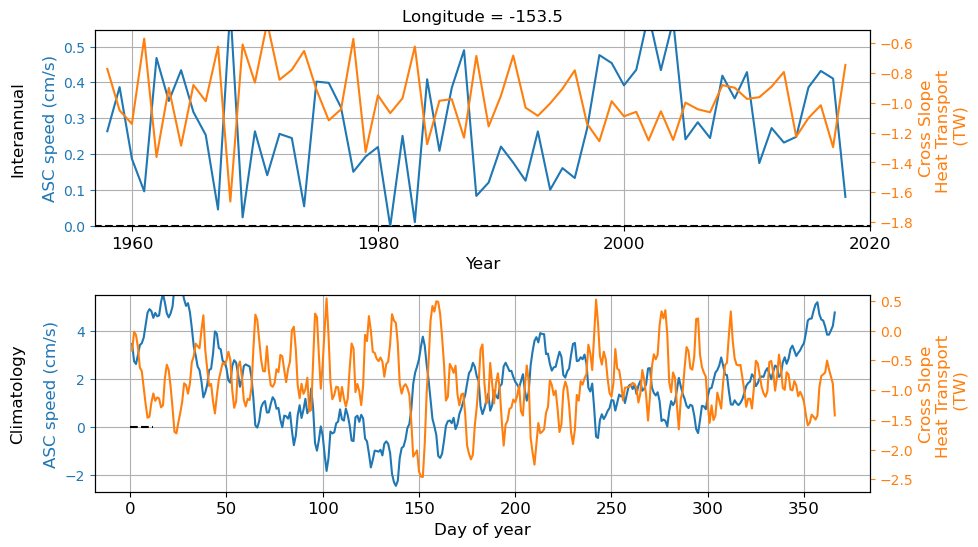

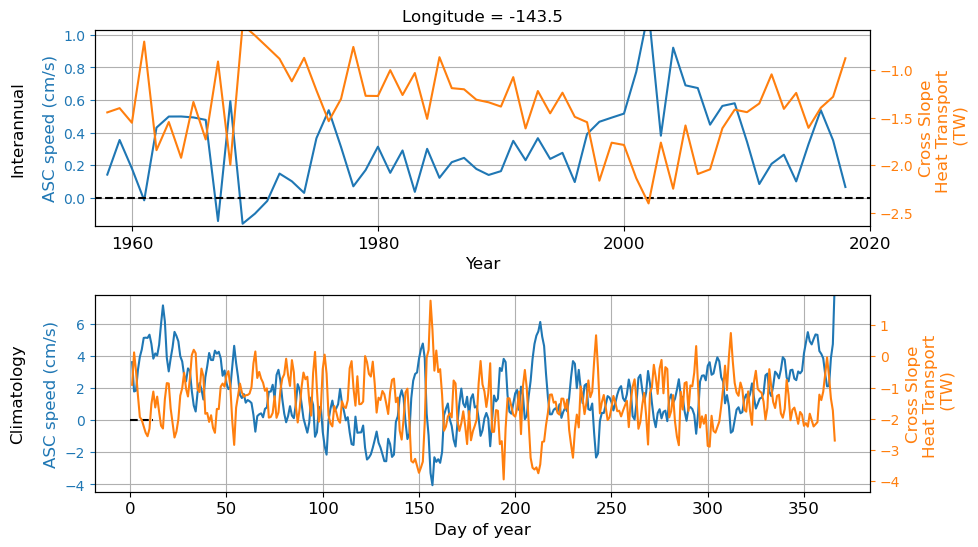

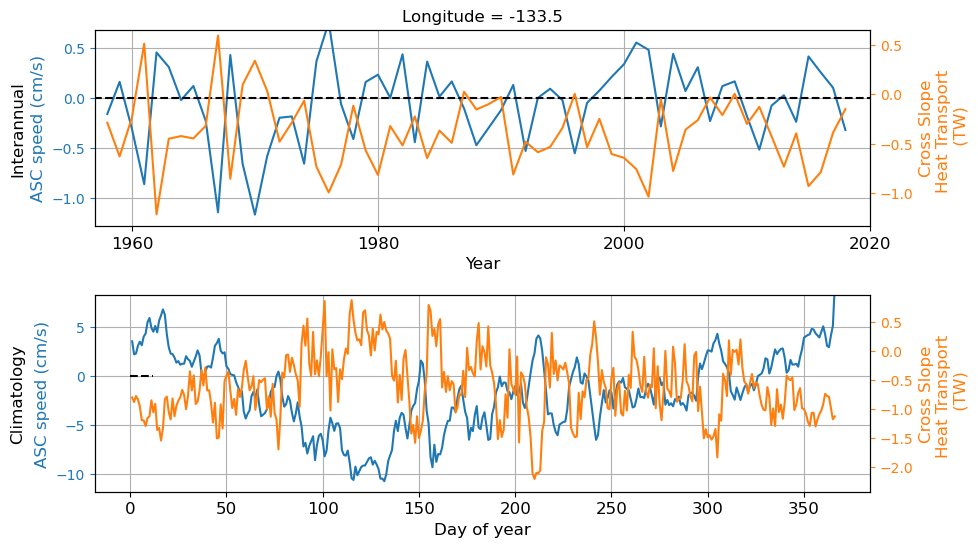

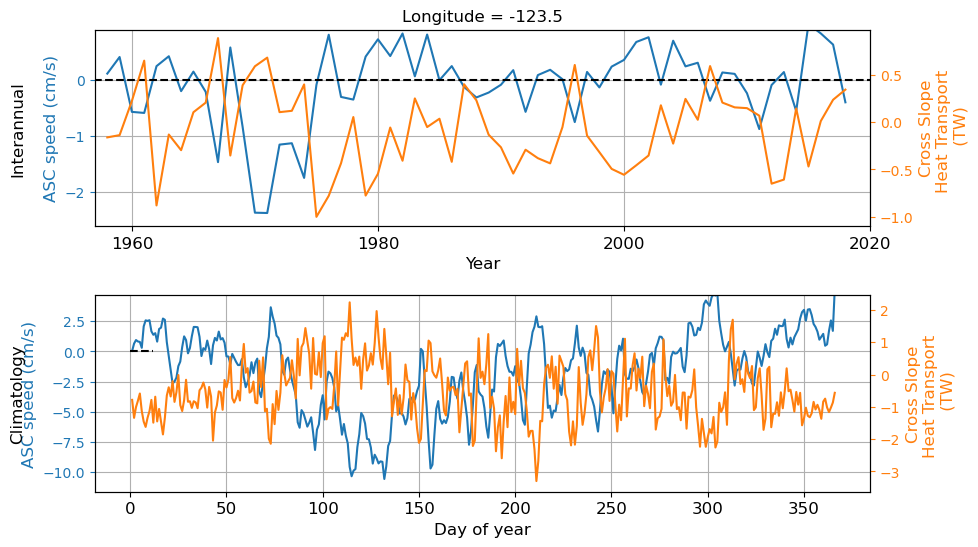

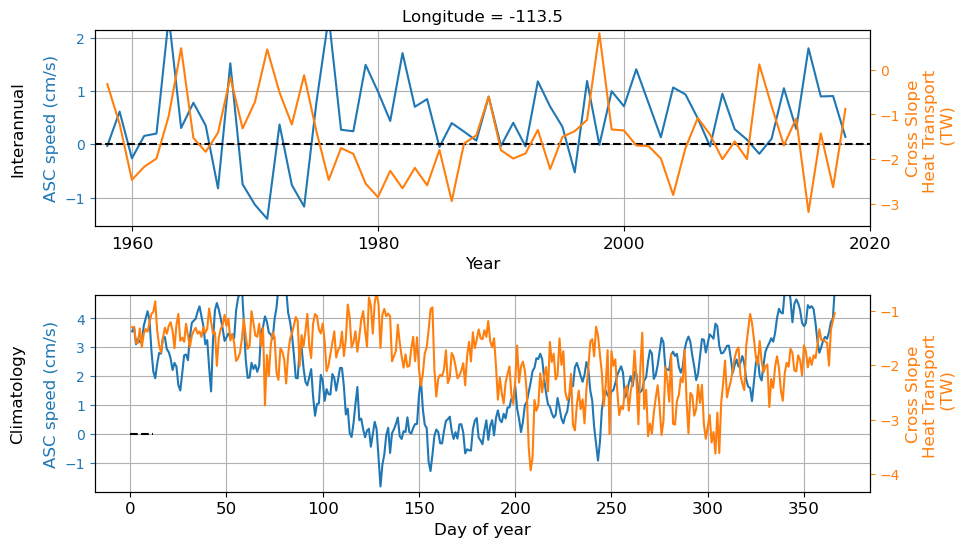

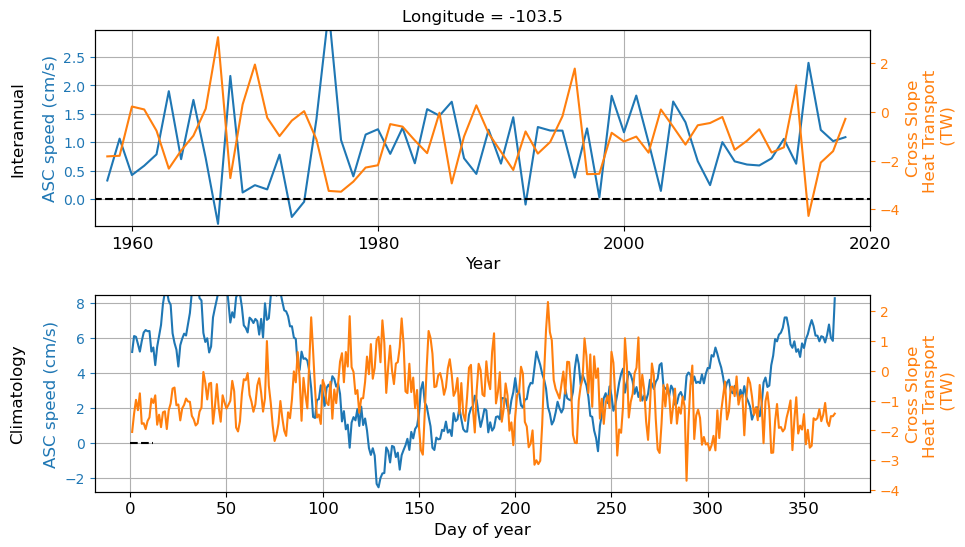

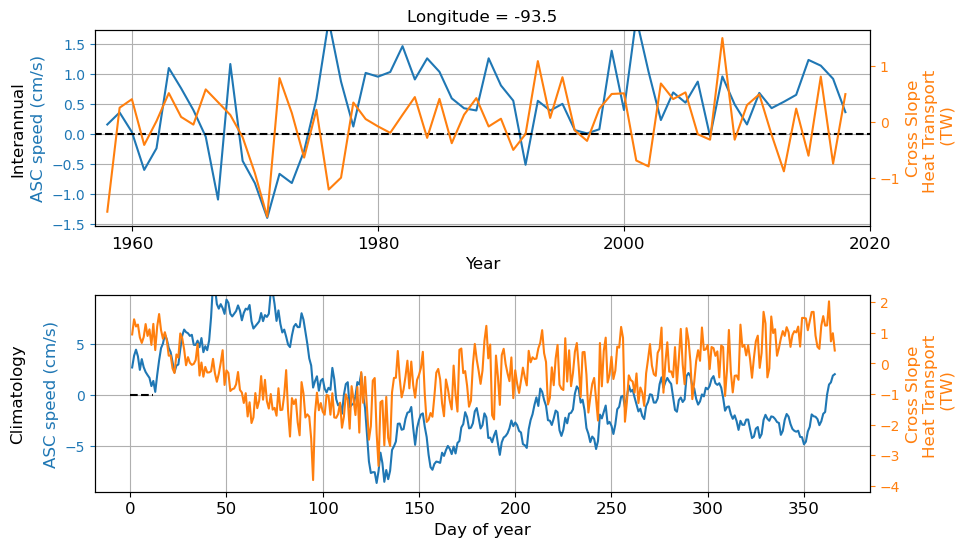

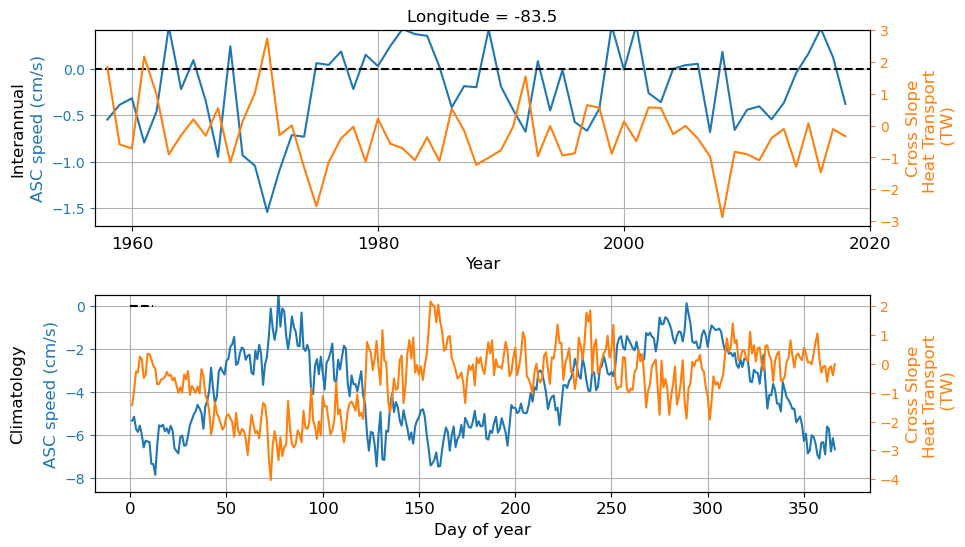

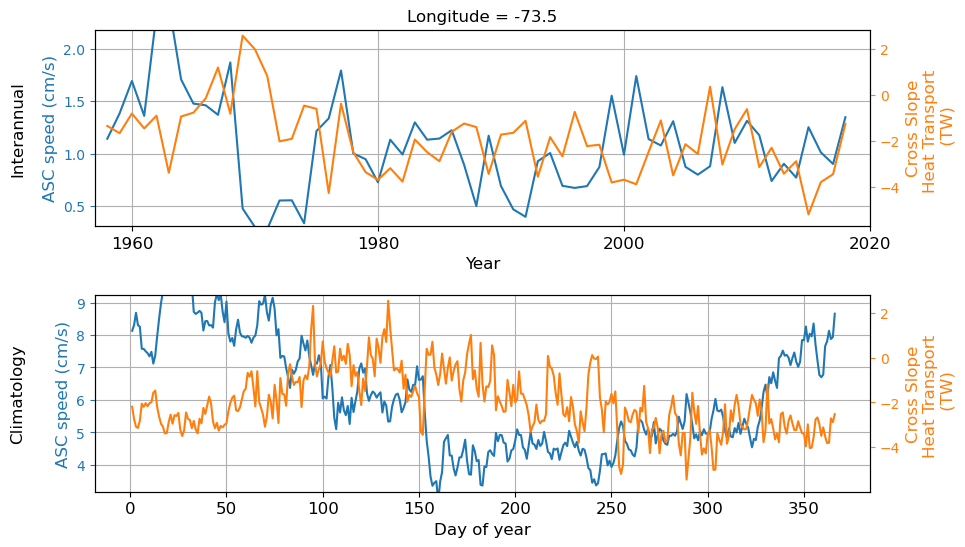

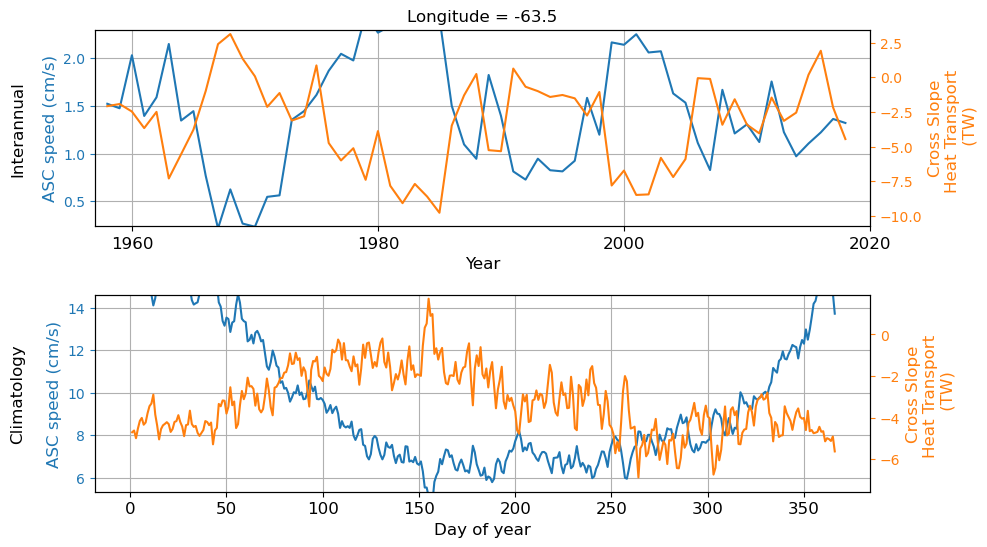

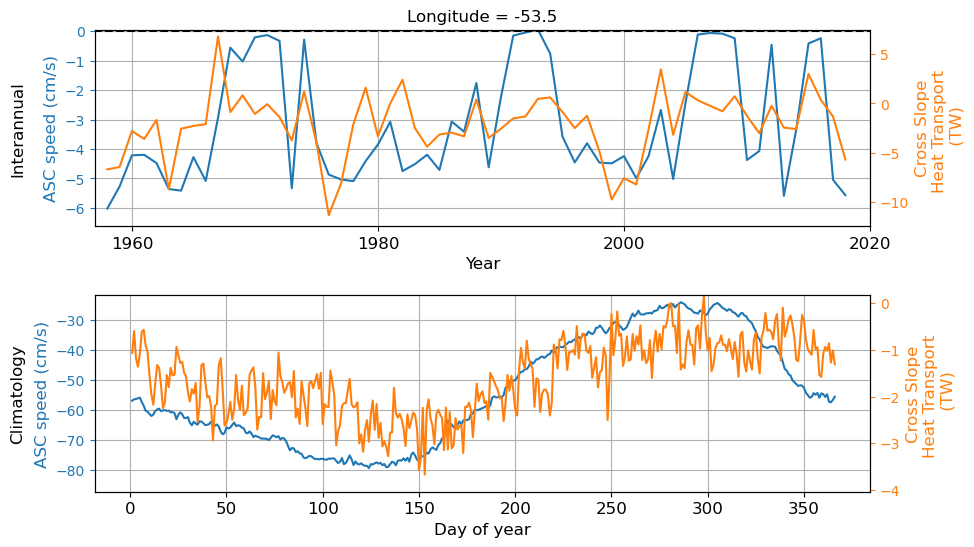

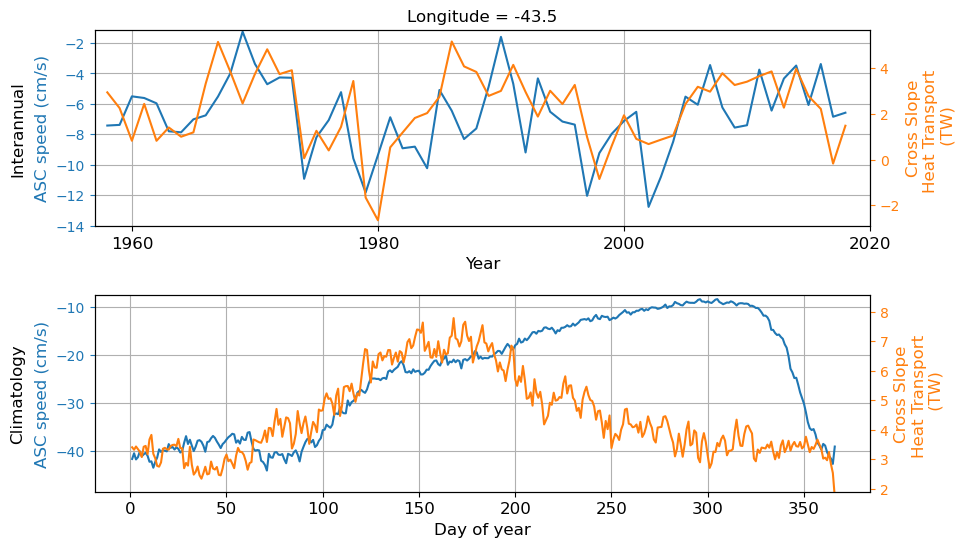

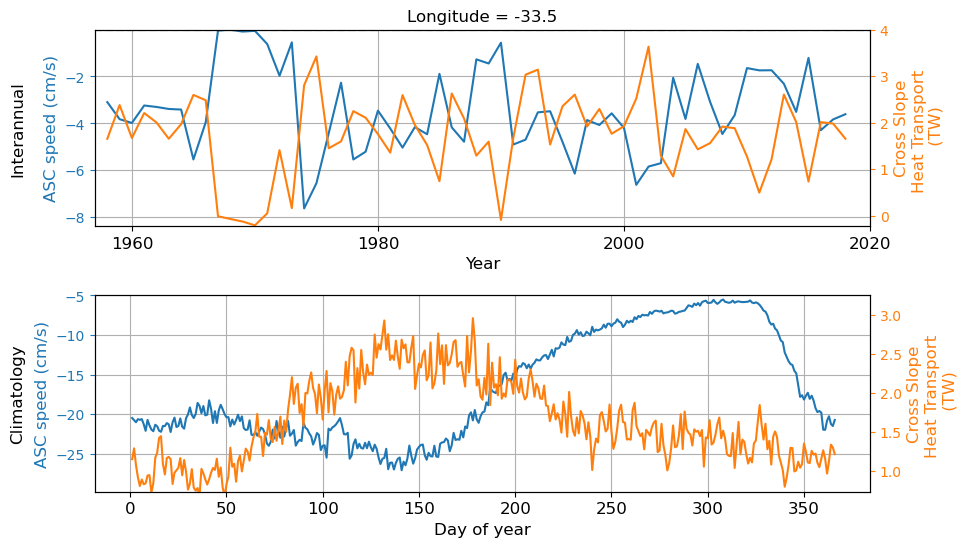

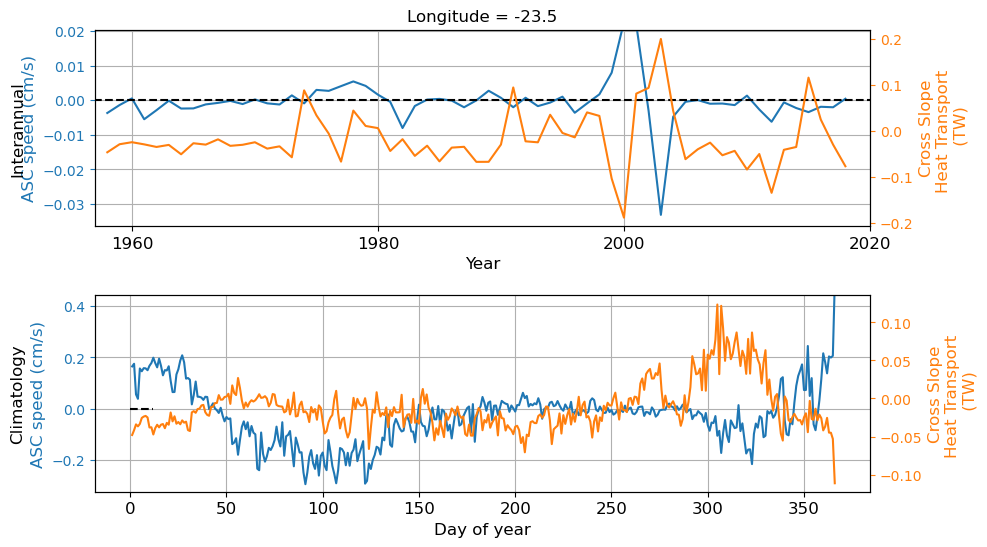

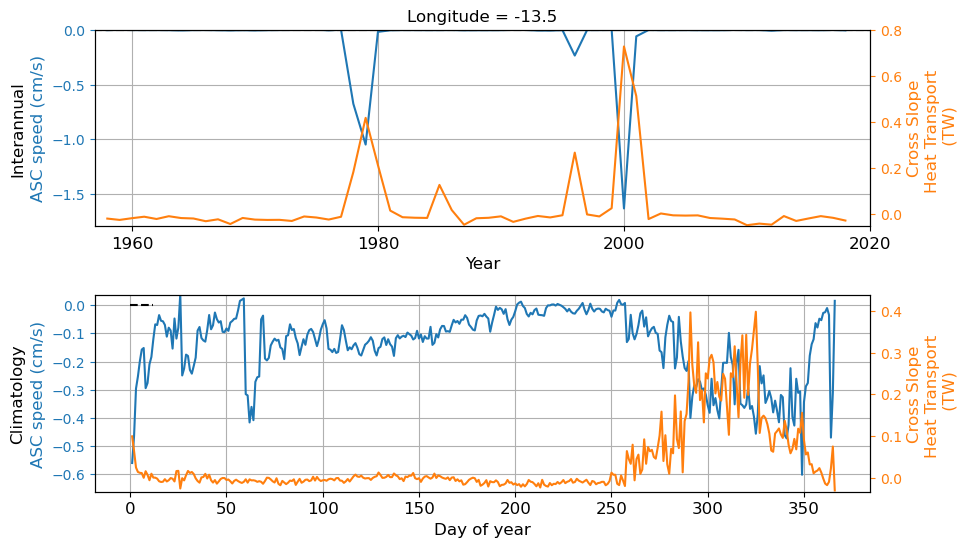

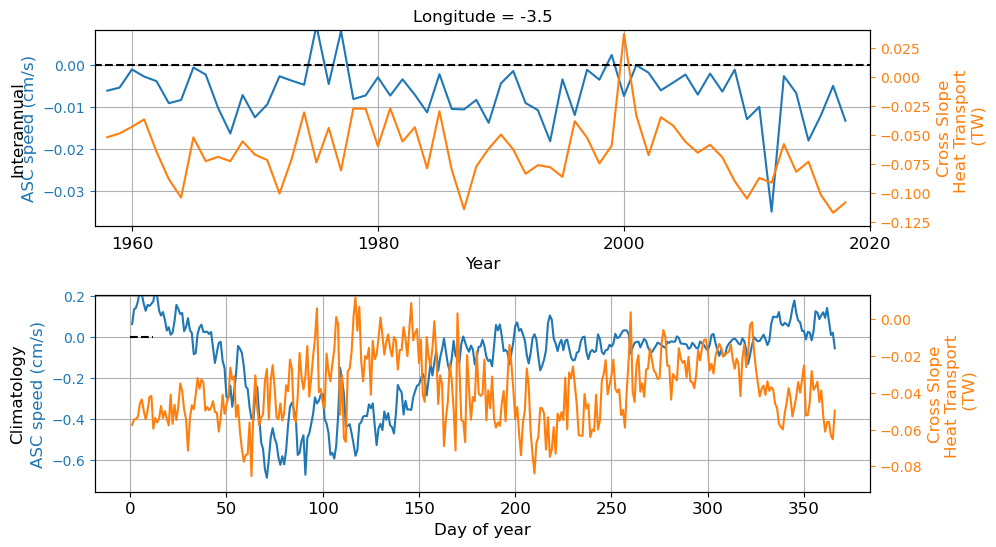

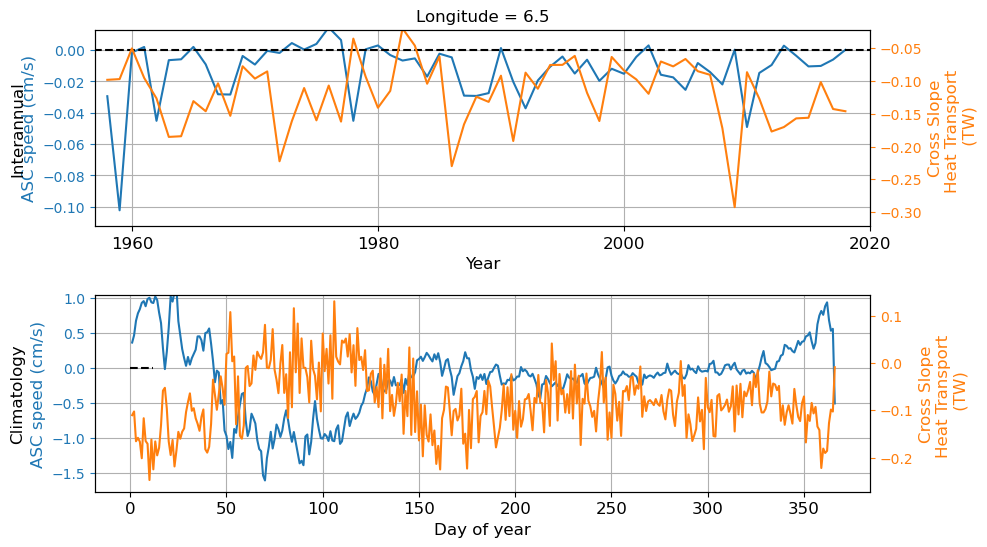

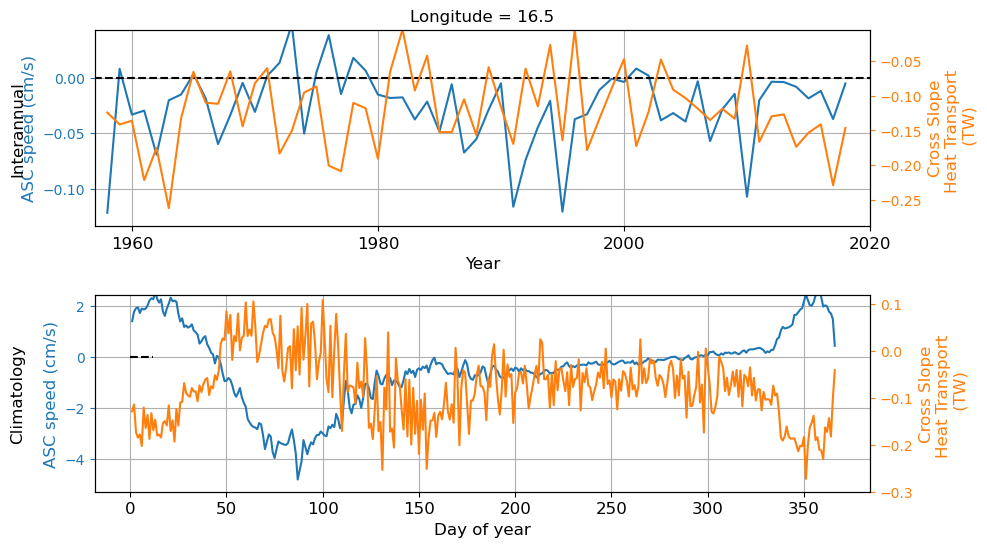

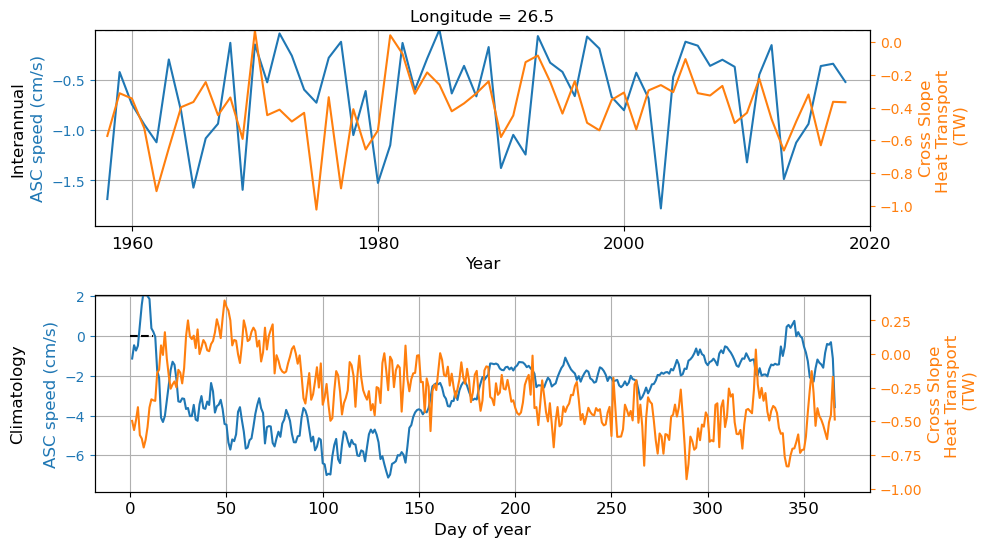

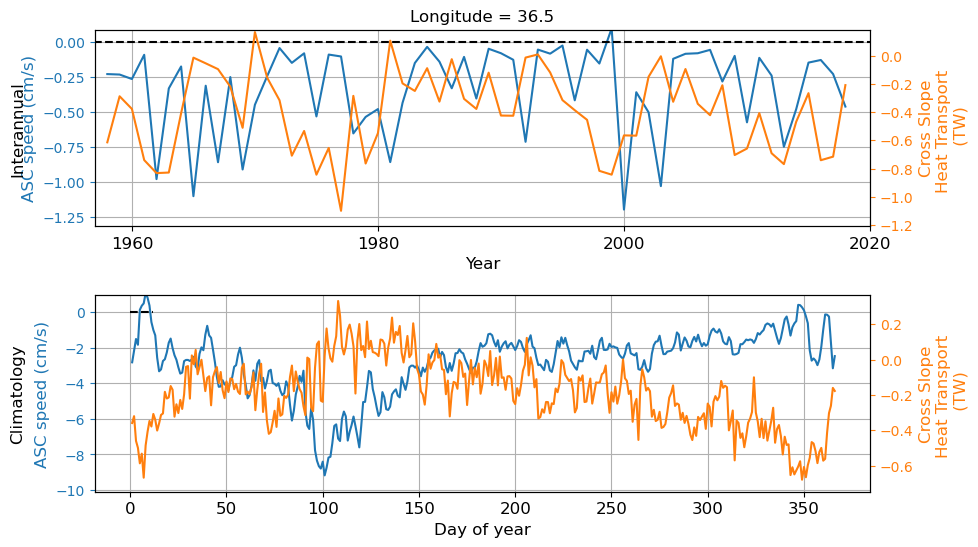

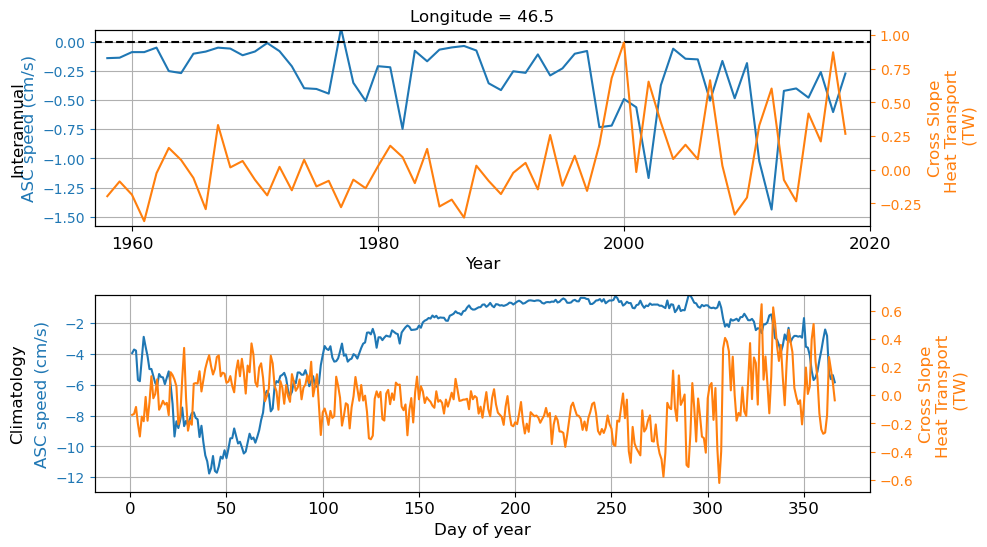

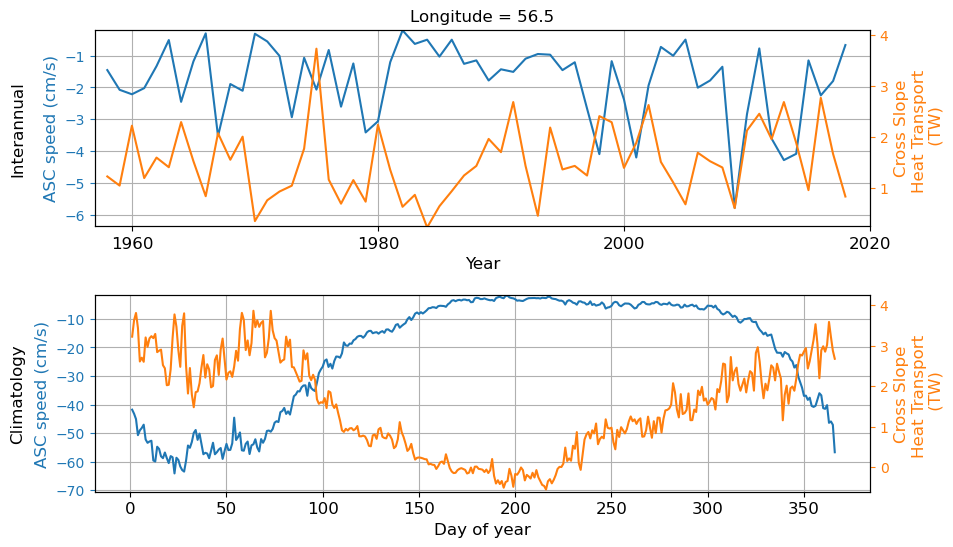

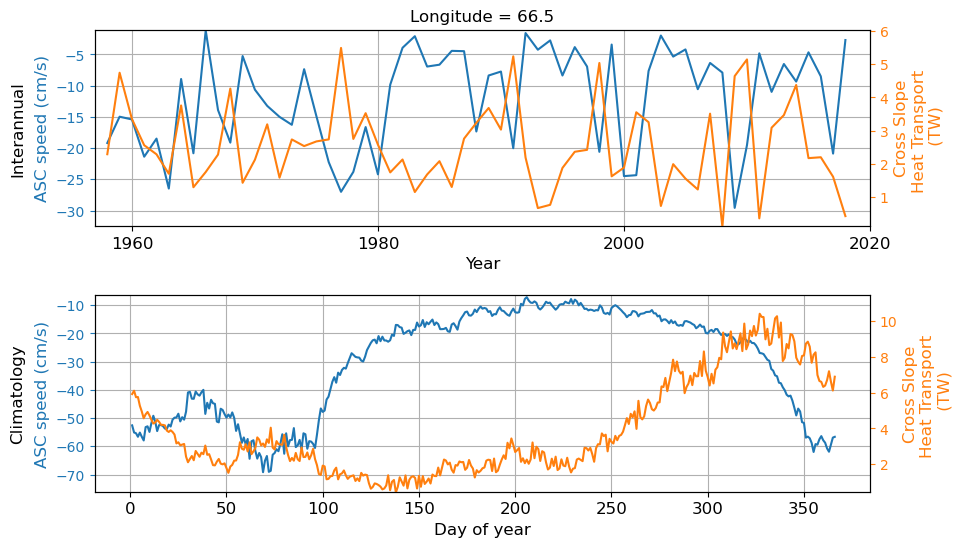

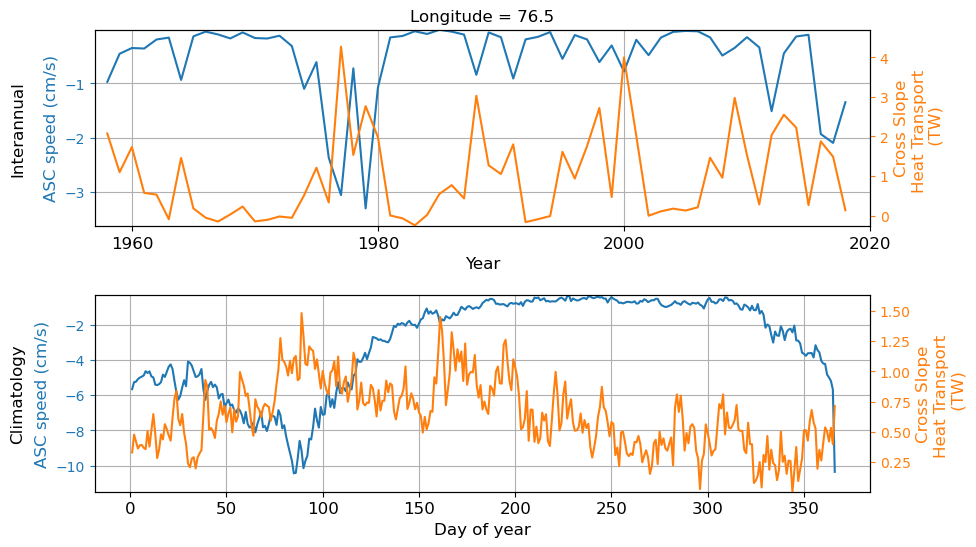

In [17]:
fontsize=12

longitude_slices = U_along_annual_binned_CDW_volav.lon_bins

for long in range(len(longitude_slices)):
    #long = 0
    
    fig = plt.figure(figsize=(10, 6))
    
    # Create a GridSpec for a 3x4 grid
    grid = gs.GridSpec(nrows=2, ncols=1, figure=fig)
    grid.update(hspace=0.35, wspace=0.95)  # Adjust vertical and horizontal spacing
    
    # Initialize a list to store axes
    axes = []
    
    ax3 = fig.add_subplot(grid[0, 0])
    ax4 = fig.add_subplot(grid[1, 0])
    ###################

    ax3_HT=ax3.twinx()
    ax3.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long])*100,label='ASC')
    ax3.plot([1956,2024],[0,0],\
             linestyle='--',color='black')
    ax3_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long])/1e12),\
                label='CSHT',color='tab:orange')
    ax3_HT.set_ylim((CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long]).min().values/1e12*1.1),
                    CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long]).max().values/1e12*1.1)
    # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    ax3.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
    ax3.set_ylim(U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long]).min().values*100*1.1,
                    U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long]).max().values*100*.9)
    # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    ax3_HT.set_ylabel('Cross Slope\nHeat Transport \n (TW)',fontsize=fontsize,color='tab:orange')
    
    ax3.set_xticks(ticks=np.arange(1960,2021,20),labels=np.arange(1960,2021,20), fontsize=fontsize)
    ax3.grid()
    ax3.set_xlim(1957,2020)
    ax3.set_xlabel('Year',fontsize=fontsize)
    ax3.tick_params(axis='y', colors='tab:blue')  # Left y-axis ticks and labels in blue
    ax3_HT.tick_params(axis='y', colors='tab:orange')  # Right y-axis ticks and labels in orange
    
    ################
    
    ax4_HT=ax4.twinx()
    ax4.plot(U_along_clima_binned_CDW_volav.dayofyear,U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long])*100,label='ASC')
    ax4.plot([0,12],[0,0],\
             linestyle='--',color='black')
    ax4_HT.plot(U_along_clima_binned_CDW_volav.dayofyear,(CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long])/1e12),\
                label='CSHT',color='tab:orange')
    ax4_HT.set_ylim((CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long]).min().values/1e12)*1.1,
                    (CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude_slices[long]).max().values/1e12)*1.1)
    ax4.set_ylim()
    # ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
    ax4.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
    # ax3_HT.set_ylim(CSHT_lims[i])
    # ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
    ax4_HT.set_ylabel('Cross Slope\nHeat Transport \n (TW)',fontsize=fontsize,color='tab:orange')
    ax4.set_xlabel('Day of year',fontsize=fontsize)
    # ax4.set_xticks(ticks=np.arange(1960,2021,10),labels=np.arange(1960,2021,10), fontsize=14)
    ax4.set_xticks(ticks=np.arange(0,365,50),labels=np.arange(0,365,50), fontsize=fontsize)
    #ax4.set_xlim(1,12)
    ax4.set_ylim(U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long]).min().values*100*1.1,
                    U_along_clima_binned_CDW_volav.U.sel(lon_bins=longitude_slices[long]).max().values*100*.9)
    ax4.grid()
    # Set tick colors
    ax4.tick_params(axis='y', colors='tab:blue')  # Left y-axis ticks and labels in blue
    ax4_HT.tick_params(axis='y', colors='tab:orange')  # Right y-axis ticks and labels in orange
    
    ax3.text(-0.1,0.5, 'Interannual', fontsize=fontsize, transform = ax3.transAxes, va = 'center', ha = 'center', rotation = 90)
    ax4.text(-0.1,0.5, 'Climatology', fontsize=fontsize, transform = ax4.transAxes, va = 'center', ha = 'center', rotation = 90)
    
    ax3.set_title('Longitude = '+str(longitude_slices[long].data))
    plt.tight_layout()
    figure_path = figdir+'time_series_'+str(longitude_slices[long].data)+'.png'
    plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')
    # Show the plots
    plt.show()